In [1]:
# Writer : JESOON KANG, Dept. of Computer Science & Engineering in Chung-Ang University
# Last-Modified Date : April 30,2020

In [114]:
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import time
import datetime
from random import *

In [115]:
### Setting up Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Below codes activates when want to use cpu
#device = torch.device('cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

GeForce RTX 2060 SUPER
Memory Usage:
Allocated: 0.5 GB
Cached:    0.6 GB


(118, 3)


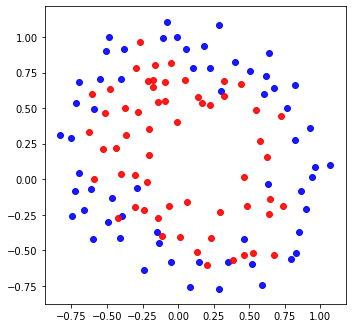

In [140]:
# Plot the training data
import numpy as np
import matplotlib.pyplot as plt

data    = np.genfromtxt("data-nonlinear.txt", delimiter=',')
print(data.shape)
x       = data[:, 0]
y       = data[:, 1]
label   = data[:, 2]

x_label0    = x[label == 0]
y_label0    = y[label == 0]

x_label1    = x[label == 1]
y_label1    = y[label == 1]

plt.figure(figsize=(5, 5))
plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [117]:
x = torch.DoubleTensor(x).to('cuda')
y = torch.DoubleTensor(y).to('cuda')
label = torch.DoubleTensor(label).to('cuda')
x = x.unsqueeze(1)
y = y.unsqueeze(1)
label = label.unsqueeze(1)

In [6]:
print(x.shape)

torch.Size([118, 1])


In [118]:
def show_graph (thetas) :
    thetas_len = len(thetas)
    
    mesh_x = torch.linspace(-2,2,256,dtype=torch.double).to('cuda')
    mesh_y = torch.linspace(-2,2,256,dtype=torch.double).to('cuda')
    XX, YY = torch.meshgrid(mesh_x,mesh_y)
    if thetas_len == 10 :
        ZZ = get_function_3(XX,YY)
    elif thetas_len == 16 :
        ZZ = get_function_4(XX,YY)

    ZZ = torch.reshape(ZZ,(thetas_len,65536))
    ZZ = torch.matmul(thetas.T,ZZ)
    ZZ = torch.reshape(ZZ,(256,256))
    yh = 1 / (1 + torch.exp(-ZZ))
    plt.figure(figsize=(6, 6))
    plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
    plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
    plt.contour(XX.cpu(), YY.cpu(), yh.cpu(), levels= [0.5], colors='g')
    plt.show()
    
def get_running_time(start_time) :
    running_time = datetime.datetime.now() - start_time
    running_time = running_time.seconds
    hours, remainder = divmod(running_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    return hours, minutes, seconds

In [9]:
%%latex
- $g(x, y ; \theta) = \sum_{i=0}^{9} \sum_{j=0}^{9} \theta_{i,j} x^{i} y^{j}$

<IPython.core.display.Latex object>

In [119]:
def get_function(x,y) :    
    ret = []
    for i in range(0,10) :
        for j in range(0,10) :
            ret.append(x**i*y**j)
    ret = torch.stack(ret).squeeze(-1)
    return ret.T


In [120]:
def get_function_test(x,y,k) :    
    ret = []
    for i in range(0,k) :
        for j in range(0,k) :
            ret.append(x**i*y**j)
    ret = torch.stack(ret).squeeze(-1)
    return ret.T
test_x = torch.DoubleTensor([2,3,4])
test_y = torch.DoubleTensor([4,5,6])
test_label = torch.DoubleTensor([0,0,1]).to('cuda')
test_fx = get_function_test(test_x,test_y,3).to('cuda')
thetas = torch.ones((9,1),dtype=torch.float64).to('cuda') * 0.01
print(thetas.shape,test_fx.shape)
z = torch.matmul(thetas.T,test_fx.T).T
print(z.shape)
activ_values = 1/(1+torch.exp(-z))
#print(activ_values.shape)
test_label = test_label.unsqueeze(1)
print(activ_values)
print(test_label)
print(activ_values - test_label)
print(test_fx[:,1].unsqueeze(1))
print((activ_values-test_label)*test_fx[:,1])
#print(test_fx)
#print(test_fx[:,2])

torch.Size([9, 1]) torch.Size([3, 9])
torch.Size([3, 1])
tensor([[0.8131],
        [0.9825],
        [0.9999]], device='cuda:0', dtype=torch.float64)
tensor([[0.],
        [0.],
        [1.]], device='cuda:0', dtype=torch.float64)
tensor([[ 8.1306e-01],
        [ 9.8254e-01],
        [-1.1975e-04]], device='cuda:0', dtype=torch.float64)
tensor([[4.],
        [5.],
        [6.]], device='cuda:0', dtype=torch.float64)
tensor([[ 3.2522e+00,  4.0653e+00,  4.8783e+00],
        [ 3.9301e+00,  4.9127e+00,  5.8952e+00],
        [-4.7899e-04, -5.9874e-04, -7.1849e-04]], device='cuda:0',
       dtype=torch.float64)


In [109]:
def get_function_test(x,y,k) :    
    ret = []
    for i in range(0,k) :
        for j in range(0,k) :
            ret.append(x**i*y**j)
    ret = torch.stack(ret)
    print("ret",ret.shape)
    ret = ret.squeeze(-1)
    print(ret.shape)
    return ret.T

fx = get_function_test(x,y,3)
print(fx.shape)
rcp_1 = 0.1
lr = 1e-3
thetas = torch.ones((9,1),dtype=torch.float64).to('cuda') * 0.01
print(thetas.shape)
epoch = 0

while (True) :
    epoch+= 1
    z = torch.matmul(fx,thetas)
    activ_values = 1/(1+torch.exp(-z))
    m = len(activ_values)

    loss = (1/m) * torch.sum(-label*torch.log(activ_values) - (1-label)*torch.log(1 - activ_values))
    loss += (rcp_1*0.5)*torch.sum(thetas**2)


    for i in range(0,len(thetas)) :
        thetas[i] -= lr * ((1/m)*torch.sum((activ_values-label)*(fx[:,i].unsqueeze(1))) + rcp_1*thetas[i])
        #thetas[i] = (1-lr*rcp_1)*thetas[i] - lr * ((1/m)*torch.sum((activ_values-label)*(fx[:,i])))
        #if i == 4 :
            #print(thetas[i])

    # calculate Accuracy        



    #test = activ_values>=0.5
    #acc = torch.sum(test==label)
    if epoch %1000 == 0 :
        output = activ_values>=0.5
        acc = output.eq(label).sum() * (1/len(activ_values))
        print(loss.item())
        print("acc : {:.5f}".format(acc))
    

ret torch.Size([9, 118, 1])
torch.Size([9, 118])
torch.Size([118, 9])
torch.Size([9, 1])
0.6901644689909949
acc : 0.55085
0.6868798925527981
acc : 0.52542
0.6844547214823491
acc : 0.52542
0.6826116308431602
acc : 0.57627
0.6811847715819863
acc : 0.61017
0.6800671920023196
acc : 0.61864
0.679185341606078
acc : 0.61864
0.6784861168863686
acc : 0.63559
0.6779298581257015
acc : 0.65254
0.6774862775393086
acc : 0.64407
0.6771319088343074
acc : 0.65254
0.6768484000794025
acc : 0.67797
0.67662130945583
acc : 0.67797
0.6764392229475248
acc : 0.67797
0.6762930910123064
acc : 0.69492
0.6761757212875531
acc : 0.70339
0.6760813862055857
acc : 0.70339


KeyboardInterrupt: 

In [91]:
rcp_1 = 0.1
lr = 1e-3
thetas = torch.ones((100,1),dtype=torch.float64).to('cuda') * 0.01
print(thetas.shape)
epoch = 0

while(True):
    epoch += 1
    z = torch.matmul(fx,thetas)
    activ_values = 1/(1+torch.exp(-z))
    m = len(activ_values)

    loss = (1/m) * torch.sum(-label*torch.log(activ_values) - (1-label)*torch.log(1 - activ_values))
    loss += (rcp_1*0.5)*torch.sum(thetas**2)

    for i in range(0,len(thetas)) :
        #thetas[i] -= lr * ((1/m)*torch.sum((activ_values-label)*(fx[:,i])) + rcp_1*thetas[i])
        thetas[i] = (1-lr*rcp_1)*thetas[i] - lr * ((1/m)*torch.sum((activ_values-label)*(fx[:,i].unsqueeze(1))))
        #if i == 4 :
            #print(thetas[i])

  
    
    # calculate Accuracy        

    
    
    #test = activ_values>=0.5
    #acc = torch.sum(test==label)
    if epoch %1000 == 0 :
        acc = 0
        for i in range(0,len(activ_values)) :
            if activ_values[i] >= 0.5 :
                if label[i] == 1 :
                    acc += 1
            else :
                if label[i] == 0 :
                    acc += 1
        acc = acc / len(activ_values)
    
        print(loss.item())
        print("acc : {:.5f}".format(acc))
        #print(thetas)
        

torch.Size([100, 1])


RuntimeError: size mismatch, m1: [118 x 9], m2: [100 x 1] at /pytorch/aten/src/THC/generic/THCTensorMathBlas.cu:290

In [126]:

# Setting Step-size. (Learning-rate)
lr = 1e-3
lr = torch.DoubleTensor([lr]).to('cuda')

# Setting converge value
loss_conv = 5e-9 # loss converge standard

# rcp : Regularisation_control_param 
rcp_1 = 0.1

# Lists for logging
loss_log = []
epoch_log = []
acc_log = []
conv_count = 0 # Variable To count converge
epoch = 0 # Inital epoch value

thetas = torch.ones((100,1),dtype=torch.float64).to('cuda')
fx = get_function(x,y)

start_time = datetime.datetime.now()
while (True) :
    epoch +=1
    epoch_log.append(epoch)
    
    z = torch.matmul(fx,thetas)
    activ_values = 1/(1+torch.exp(-z))
    m = len(activ_values)
    
    loss = (1/m) * torch.sum(-label*torch.log(activ_values) - (1-label)*torch.log(1 - activ_values))
    loss += rcp_1/2*torch.sum(thetas**2)

    #for i in range(0,len(thetas)) :
    #    thetas[i] = (1-lr*rcp_1)*thetas[i] - lr * ((1/m)*torch.sum((activ_values-label)*(fx[:,i].unsqueeze(1))))
    
    for i in range(0,len(thetas)) :
        thetas[i] -= lr * ((1/m)*torch.sum((activ_values-label)*(fx[:,i].unsqueeze(1))) + rcp_1*thetas[i])
    
    
    
    # Calculate accuracy
    output = activ_values>=0.5
    acc = output.eq(label).sum() * (1/len(activ_values))
    
    
    
    # Logging
    loss_log.append(loss)
    acc_log.append(acc)

    ## Does Train Loss Converged?
    if len(loss_log) > 2 :
        if abs(loss_log[-1] - loss_log[-2]) < loss_conv :
            conv_count += 1
        else :
            conv_count = 0
    

    # For monitoring
    if epoch %1000 == 0 :        
        running_time = get_running_time(start_time)
        print("lr : {}, epoch {},loss {:.10f}, acc {:.3f}, time : {:02d}:{:02d}:{:02d}".\
              format(lr.item(), epoch,loss_log[-1],acc_log[-1],running_time[0],running_time[1],running_time[2]) )
        #show_graph(thetas)
    ## Escape if Training loss is converged
    if conv_count > 4 :
        # Loss converged
        running_time = get_running_time(start_time)
        print("lr : {}, epoch {},loss {:.10f}, acc {:.3f}, time : {:02d}:{:02d}:{:02d}".\
              format(lr.item(), epoch,loss_log[-1],acc_log[-1],running_time[0],running_time[1],running_time[2]) )
        
        print("converged")
        break


lr : 0.001, epoch 1000,loss 6.0330361849, acc 0.492, time : 00:00:09
lr : 0.001, epoch 2000,loss 4.8343658786, acc 0.585, time : 00:00:18
lr : 0.001, epoch 3000,loss 3.8999195562, acc 0.534, time : 00:00:28
lr : 0.001, epoch 4000,loss 3.1755707948, acc 0.483, time : 00:00:37
lr : 0.001, epoch 5000,loss 2.6166208502, acc 0.458, time : 00:00:47
lr : 0.001, epoch 6000,loss 2.1862409625, acc 0.432, time : 00:00:56
lr : 0.001, epoch 7000,loss 1.8548011770, acc 0.390, time : 00:01:06
lr : 0.001, epoch 8000,loss 1.5987623354, acc 0.373, time : 00:01:15


KeyboardInterrupt: 

In [12]:
from IPython.display import display, Math, Latex

# Result Section

# 1. Plot the training data

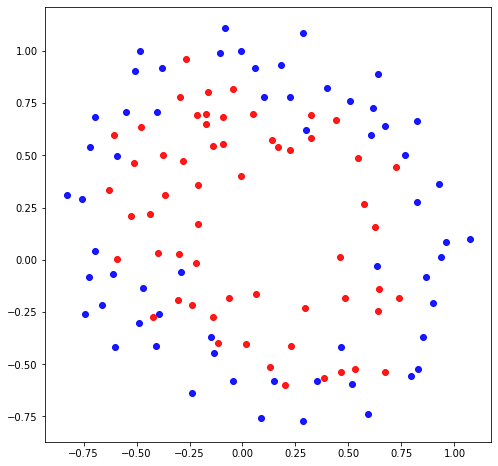

In [114]:
plt.figure(figsize=(8, 8))
plt.scatter(x_label0, y_label0, alpha=0.9, c='b')
plt.scatter(x_label1, y_label1, alpha=0.9, c='r')
plt.show()

# 2. Write down the high dimensional function $g(x, y); \theta)$

${\small
  g(x, y ; \theta) =
  1\times 
  f_{0}(x, y)
  + x f_{1}(x, y)
  + y f_{2}(x, y)
  \\ \small
  + xy f_{3}(x, y)
  + x^{2} f_{4}(x, y)
  + y^{2} f_{5}(x, y)
  + x^{2}y f_{6}(x, y)
  \\ \small
  + xy^{2} f_{7}(x, y)
  + x^{3} f_{8}(x, y)
  + y^{3} f_{9}(x, y)
  + x^{3}y f_{10}(x, y)
  \\ \small
  + xy^{3} f_{11}(x, y)
  + x^{3}y^{2} f_{12}(x, y)
  + x^{2}y^{3} f_{13}(x, y)
  + x^{3}y^{3} f_{14}(x, y)
  + x^{5}y^{5} f_{15}(x, y)
}$


# 3. Plot the training error

Converged Training loss : 0.69315


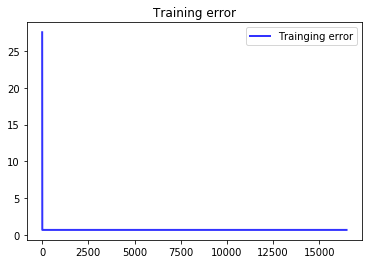

In [115]:
plt.title("Training error")
plot, = plt.plot(epoch_log,loss_log, color='blue',linewidth=2,alpha=0.8)
plt.legend([plot],["Trainging error"])
print("Converged Training loss : {:.5f}".format(loss_log[-1].item()))

# 4. Plot the training accuracy

ValueError: x and y must have same first dimension, but have shapes (16472,) and (16471,)

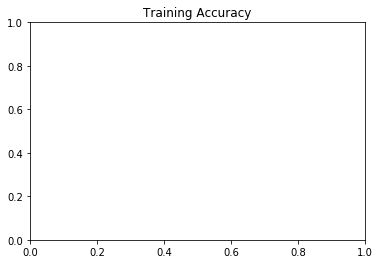

In [116]:
plt.title("Training Accuracy")
plot, = plt.plot(epoch_log,acc_log, color='red',linewidth=2,alpha=0.8)
plt.legend([plot],["Trainging error"])
print("Converged Training Accuracy : {:.5f}".format(acc_log[-1]))

# 5. Write down the final training accuracy

## Final training accuracy : 84.746%

# 6. Plot the optimal classifier superimposed on the training data

In [117]:
thetas_4 = thetas
show_graph(thetas_4)

UnboundLocalError: local variable 'ZZ' referenced before assignment